## 1. Setup and Data Loading

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# Load the data
df = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (104, 5)

Column names: ['id', 'job_title', 'location', 'connection', 'fit']

First few rows:


,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources prof...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,9,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
9,10,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,NaN


In [5]:
# Data exploration
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nBasic Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB
None


Missing Values:
id              0
job_title       0
location        0
connection      0
fit           104
dtype: int64


Basic Statistics:
               id  fit
count  104.000000  0.0
mean    52.500000  NaN
std     30.166206  NaN
min      1.000000  NaN
25%     26.750000  NaN
50%     52.500000  NaN
75%     78.250000  NaN
max    104.000000  NaN


In [6]:
# Check for duplicate entries
print(f"Number of unique candidates: {df['id'].nunique()}")
print(f"Number of duplicate job titles: {df.duplicated(subset=['job_title', 'location']).sum()}")
print(f"\nSample job titles:")
for i, title in enumerate(df['job_title'].head(10)):
    print(f"{i+1}. {title}")

Number of unique candidates: 104
Number of duplicate job titles: 51

Sample job titles:
1. 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
2. Native English Teacher at EPIK (English Program in Korea)
3. Aspiring Human Resources Professional
4. People Development Coordinator at Ryan
5. Advisory Board Member at Celal Bayar University
6. Aspiring Human Resources Specialist
7. Student at Humber College and Aspiring Human Resources Generalist
8. HR Senior Specialist
9. Student at Humber College and Aspiring Human Resources Generalist
10. Seeking Human Resources HRIS and Generalist Positions


## 2. Initial Ranking Algorithm

We'll use **TF-IDF (Term Frequency-Inverse Document Frequency)** with **Cosine Similarity** to:
- Measure how well each candidate's job title matches the target role keywords
- Create an initial fitness score

In [7]:
class TalentRankingSystem:
    """
    A ranking system that scores candidates and learns from human feedback.
    """
    
    def __init__(self, keywords, use_connections=True):
        """
        Initialize the ranking system.
        
        Parameters:
        -----------
        keywords : str or list
            Target role keywords to match against
        use_connections : bool
            Whether to factor in number of connections
        """
        self.keywords = keywords if isinstance(keywords, str) else ' '.join(keywords)
        self.use_connections = use_connections
        self.vectorizer = TfidfVectorizer(
            stop_words='english',
            ngram_range=(1, 3),  # Use unigrams, bigrams, and trigrams
            min_df=1,
            lowercase=True
        )
        self.starred_candidates = []
        self.ranking_history = []
        
    def preprocess_text(self, text):
        """Clean and preprocess text data."""
        if pd.isna(text):
            return ""
        # Convert to lowercase and remove special characters
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return text
    
    def normalize_connections(self, connections_series):
        """
        Normalize connection counts to 0-1 scale.
        Handles '500+' format.
        """
        def parse_connection(conn):
            if pd.isna(conn):
                return 0
            conn_str = str(conn).strip()
            if '500+' in conn_str:
                return 500
            try:
                return int(conn_str)
            except:
                return 0
        
        connections_numeric = connections_series.apply(parse_connection)
        max_conn = connections_numeric.max()
        if max_conn > 0:
            return connections_numeric / max_conn
        return connections_numeric
    
    def calculate_initial_fit(self, df):
        """
        Calculate initial fitness scores using TF-IDF and cosine similarity.
        """
        # Preprocess job titles
        df['processed_title'] = df['job_title'].apply(self.preprocess_text)
        
        # Create TF-IDF matrix
        all_texts = [self.keywords] + df['processed_title'].tolist()
        tfidf_matrix = self.vectorizer.fit_transform(all_texts)
        
        # Calculate cosine similarity between keywords and each job title
        keyword_vector = tfidf_matrix[0:1]
        candidate_vectors = tfidf_matrix[1:]
        
        similarities = cosine_similarity(keyword_vector, candidate_vectors).flatten()
        
        # Factor in connections if enabled
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            # Weighted combination: 80% text similarity, 20% connections
            final_scores = 0.8 * similarities + 0.2 * connection_scores
        else:
            final_scores = similarities
        
        return final_scores
    
    def calculate_fit_with_feedback(self, df, starred_indices):
        """
        Recalculate fitness scores incorporating starred candidates as positive examples.
        Uses a hybrid approach combining keyword matching and similarity to starred profiles.
        """
        # Preprocess job titles
        df['processed_title'] = df['job_title'].apply(self.preprocess_text)
        
        # Create TF-IDF matrix
        all_texts = [self.keywords] + df['processed_title'].tolist()
        tfidf_matrix = self.vectorizer.fit_transform(all_texts)
        
        # Base similarity to keywords
        keyword_vector = tfidf_matrix[0:1]
        candidate_vectors = tfidf_matrix[1:]
        keyword_similarities = cosine_similarity(keyword_vector, candidate_vectors).flatten()
        
        if len(starred_indices) > 0:
            # Calculate similarity to starred candidates
            starred_vectors = candidate_vectors[starred_indices]
            
            # For each candidate, get max similarity to any starred candidate
            starred_similarities = cosine_similarity(candidate_vectors, starred_vectors)
            max_starred_sim = starred_similarities.max(axis=1)
            
            # Combine: give more weight to starred similarity as we get more feedback
            weight_starred = min(0.6, 0.3 + (len(starred_indices) * 0.05))
            weight_keyword = 1 - weight_starred
            
            combined_scores = (weight_keyword * keyword_similarities + 
                             weight_starred * max_starred_sim)
        else:
            combined_scores = keyword_similarities
        
        # Factor in connections
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.85 * combined_scores + 0.15 * connection_scores
        else:
            final_scores = combined_scores
        
        return final_scores
    
    def rank_candidates(self, df, starred_indices=None):
        """
        Rank candidates and return sorted dataframe.
        """
        df_copy = df.copy()
        
        if starred_indices is None or len(starred_indices) == 0:
            fit_scores = self.calculate_initial_fit(df_copy)
        else:
            fit_scores = self.calculate_fit_with_feedback(df_copy, starred_indices)
        
        df_copy['fit'] = fit_scores
        df_copy = df_copy.sort_values('fit', ascending=False).reset_index(drop=True)
        df_copy['rank'] = range(1, len(df_copy) + 1)
        
        # Store ranking history
        self.ranking_history.append(df_copy[['id', 'rank', 'fit']].copy())
        
        return df_copy
    
    def star_candidate(self, df, candidate_rank):
        """
        Star a candidate at given rank position and re-rank all candidates.
        """
        # Get the candidate's original index
        candidate_idx = df.index[df['rank'] == candidate_rank].tolist()[0]
        
        if candidate_idx not in self.starred_candidates:
            self.starred_candidates.append(candidate_idx)
            print(f"✭ Starred candidate at rank {candidate_rank}: {df.loc[candidate_idx, 'job_title']}")
        
        # Re-rank with updated feedback
        return self.rank_candidates(df, self.starred_candidates)

print("TalentRankingSystem class defined successfully!")

TalentRankingSystem class defined successfully!


In [8]:
# Initialize the ranking system
keywords = "aspiring human resources seeking human resources"
ranking_system = TalentRankingSystem(keywords, use_connections=True)

print(f"Ranking system initialized with keywords: '{keywords}'")
print(f"Connection factor: {ranking_system.use_connections}")

Ranking system initialized with keywords: 'aspiring human resources seeking human resources'
Connection factor: True


In [9]:
# Perform initial ranking
ranked_df = ranking_system.rank_candidates(df)

print("Initial Ranking Complete!")
print(f"\nTop 15 Candidates:")
print("="*100)
ranked_df[['rank', 'job_title', 'location', 'connection', 'fit']].head(15)

Initial Ranking Complete!

Top 15 Candidates:


,rank,job_title,location,connection,fit
0,1,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.461002
1,2,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.461002
2,3,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.416951
3,4,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.416951
4,5,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.416951
5,6,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.416951
6,7,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.352899
7,8,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.352899
8,9,Seeking Human Resources Opportunities. Open to travel and relocation.,Amerika Birleşik Devletleri,415,0.329266
9,10,"Nortia Staffing is seeking Human Resources, Payroll & Administrative Professionals!! (408) 709-...","San Jose, California",500+,0.315258


## 3. Visualize Initial Rankings

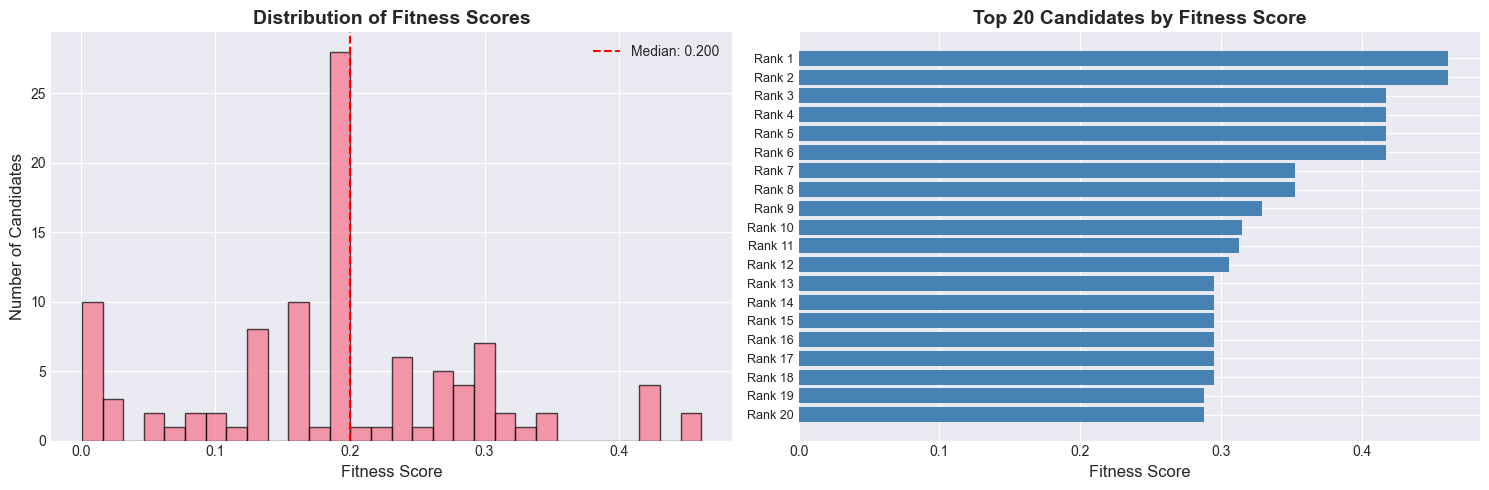


Fitness Score Statistics:
Mean: 0.1938
Median: 0.2000
Std Dev: 0.1066
Min: 0.0008
Max: 0.4610


In [10]:
# Distribution of fitness scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(ranked_df['fit'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Fitness Score', fontsize=12)
axes[0].set_ylabel('Number of Candidates', fontsize=12)
axes[0].set_title('Distribution of Fitness Scores', fontsize=14, fontweight='bold')
axes[0].axvline(ranked_df['fit'].median(), color='red', linestyle='--', label=f'Median: {ranked_df["fit"].median():.3f}')
axes[0].legend()

# Top 20 candidates bar plot
top_20 = ranked_df.head(20)
axes[1].barh(range(len(top_20)), top_20['fit'], color='steelblue')
axes[1].set_yticks(range(len(top_20)))
axes[1].set_yticklabels([f"Rank {r}" for r in top_20['rank']], fontsize=9)
axes[1].set_xlabel('Fitness Score', fontsize=12)
axes[1].set_title('Top 20 Candidates by Fitness Score', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nFitness Score Statistics:")
print(f"Mean: {ranked_df['fit'].mean():.4f}")
print(f"Median: {ranked_df['fit'].median():.4f}")
print(f"Std Dev: {ranked_df['fit'].std():.4f}")
print(f"Min: {ranked_df['fit'].min():.4f}")
print(f"Max: {ranked_df['fit'].max():.4f}")

## 4. Interactive Re-ranking with Starring

Simulate the human review process where recruiters star candidates they find ideal.

In [11]:
# Simulate starring candidates - Example 1: Star the 7th ranked candidate
print("ITERATION 1: Starring candidate at rank 7")
print("="*100)

ranked_df = ranking_system.star_candidate(ranked_df, candidate_rank=7)

print(f"\nUpdated Top 15 Rankings:")
ranked_df[['rank', 'job_title', 'location', 'connection', 'fit']].head(15)

ITERATION 1: Starring candidate at rank 7
✭ Starred candidate at rank 7: Aspiring Human Resources Management student seeking an internship

Updated Top 15 Rankings:


,rank,job_title,location,connection,fit
0,1,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.553096
1,2,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.553096
2,3,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.358885
3,4,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.358885
4,5,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.322055
5,6,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.322055
6,7,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.322055
7,8,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.322055
8,9,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,0.273432
9,10,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.265332


In [12]:
# Simulate starring another candidate - Example 2: Star rank 3
print("ITERATION 2: Starring candidate at rank 3")
print("="*100)

ranked_df = ranking_system.star_candidate(ranked_df, candidate_rank=3)

print(f"\nUpdated Top 15 Rankings:")
ranked_df[['rank', 'job_title', 'location', 'connection', 'fit']].head(15)

ITERATION 2: Starring candidate at rank 3
✭ Starred candidate at rank 3: Seeking Human Resources Opportunities

Updated Top 15 Rankings:


,rank,job_title,location,connection,fit
0,1,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.651439
1,2,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.651439
2,3,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.628306
3,4,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.628306
4,5,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.628306
5,6,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.628306
6,7,Seeking Human Resources Opportunities. Open to travel and relocation.,Amerika Birleşik Devletleri,415,0.410583
7,8,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,0.334722
8,9,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.283179
9,10,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.283179


In [13]:
# Simulate starring another candidate - Example 3: Star rank 12
print("ITERATION 3: Starring candidate at rank 12")
print("="*100)

ranked_df = ranking_system.star_candidate(ranked_df, candidate_rank=12)

print(f"\nUpdated Top 15 Rankings:")
ranked_df[['rank', 'job_title', 'location', 'connection', 'fit']].head(15)

ITERATION 3: Starring candidate at rank 12
✭ Starred candidate at rank 12: Human Resources Generalist at Loparex

Updated Top 15 Rankings:


,rank,job_title,location,connection,fit
0,1,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.659281
1,2,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.659281
2,3,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.659281
3,4,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.659281
4,5,Seeking Human Resources Opportunities. Open to travel and relocation.,Amerika Birleşik Devletleri,415,0.602409
5,6,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,0.583787
6,7,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.499986
7,8,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.499986
8,9,Human Resources Generalist at Schwan's,Amerika Birleşik Devletleri,500+,0.328650
9,10,"Human Resources Generalist at ScottMadden, Inc.","Raleigh-Durham, North Carolina Area",500+,0.328650


## 5. Visualize Ranking Improvements

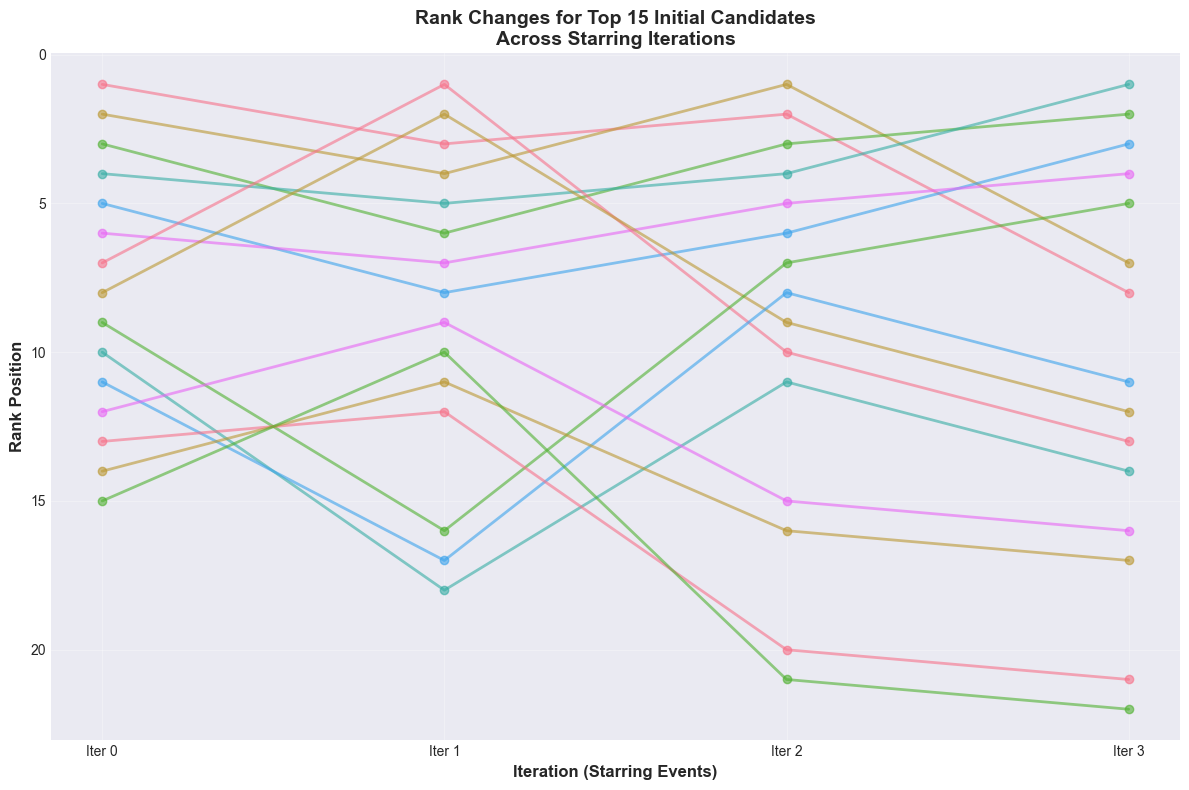

In [14]:
# Track how rankings change over iterations
def track_ranking_changes(ranking_history, num_top_candidates=20):
    """
    Visualize how top candidates' ranks change over iterations.
    """
    if len(ranking_history) < 2:
        print("Need at least 2 ranking iterations to show changes.")
        return
    
    # Get IDs of top candidates from initial ranking
    initial_top_ids = ranking_history[0].head(num_top_candidates)['id'].tolist()
    
    # Track their ranks across iterations
    rank_progression = {}
    for candidate_id in initial_top_ids:
        ranks = []
        for iteration in ranking_history:
            rank = iteration[iteration['id'] == candidate_id]['rank'].values[0]
            ranks.append(rank)
        rank_progression[candidate_id] = ranks
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for candidate_id, ranks in rank_progression.items():
        ax.plot(range(len(ranks)), ranks, marker='o', alpha=0.6, linewidth=2)
    
    ax.set_xlabel('Iteration (Starring Events)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rank Position', fontsize=12, fontweight='bold')
    ax.set_title(f'Rank Changes for Top {num_top_candidates} Initial Candidates\nAcross Starring Iterations', 
                 fontsize=14, fontweight='bold')
    ax.invert_yaxis()  # Lower rank number = better
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(len(ranking_history)))
    ax.set_xticklabels([f'Iter {i}' for i in range(len(ranking_history))])
    
    plt.tight_layout()
    plt.show()

track_ranking_changes(ranking_system.ranking_history, num_top_candidates=15)

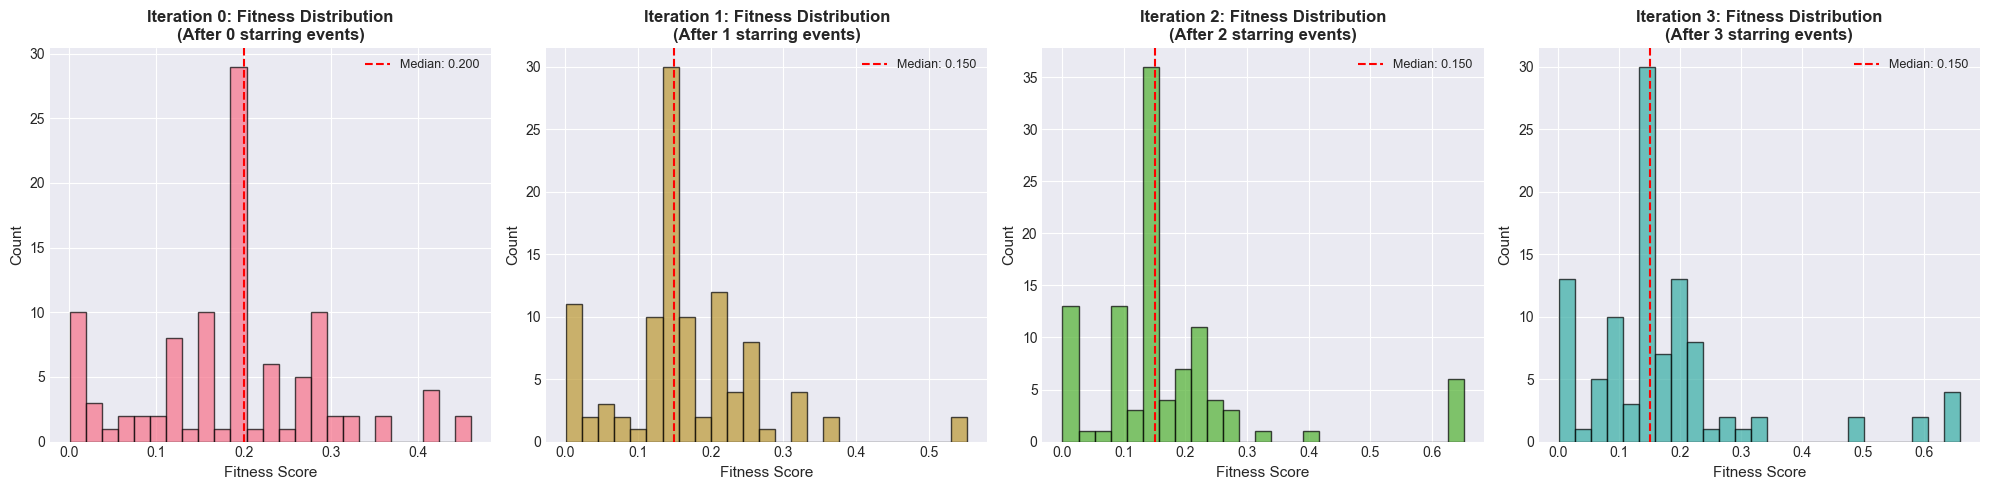

In [15]:
# Compare fitness score distributions across iterations
fig, axes = plt.subplots(1, len(ranking_system.ranking_history), 
                         figsize=(5*len(ranking_system.ranking_history), 5))

if len(ranking_system.ranking_history) == 1:
    axes = [axes]

for idx, (iteration, ax) in enumerate(zip(ranking_system.ranking_history, axes)):
    ax.hist(iteration['fit'], bins=25, edgecolor='black', alpha=0.7, color=f'C{idx}')
    ax.set_xlabel('Fitness Score', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'Iteration {idx}: Fitness Distribution\n(After {idx} starring events)', 
                 fontsize=12, fontweight='bold')
    ax.axvline(iteration['fit'].median(), color='red', linestyle='--', 
               label=f'Median: {iteration["fit"].median():.3f}')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

## 6. Filtering and Cut-off Analysis

Determine optimal thresholds to filter out poor-fit candidates.

In [16]:
def analyze_cutoff_points(df, percentiles=[25, 50, 75, 90]):
    """
    Analyze different cut-off points for filtering candidates.
    """
    print("Cut-off Point Analysis")
    print("="*80)
    
    for percentile in percentiles:
        threshold = np.percentile(df['fit'], percentile)
        num_candidates = (df['fit'] >= threshold).sum()
        
        print(f"\n{percentile}th Percentile (threshold = {threshold:.4f}):")
        print(f"  → Candidates retained: {num_candidates} ({num_candidates/len(df)*100:.1f}%)")
        print(f"  → Candidates filtered: {len(df) - num_candidates} ({(len(df)-num_candidates)/len(df)*100:.1f}%)")
    
    # Elbow method: find point where fitness drops significantly
    sorted_fit = df.sort_values('fit', ascending=False)['fit'].values
    differences = np.diff(sorted_fit)
    
    # Find largest drop
    max_drop_idx = np.argmax(np.abs(differences))
    elbow_threshold = sorted_fit[max_drop_idx]
    elbow_candidates = (df['fit'] >= elbow_threshold).sum()
    
    print(f"\n{'='*80}")
    print(f"Elbow Method Recommendation (largest fitness drop):")
    print(f"  → Threshold: {elbow_threshold:.4f}")
    print(f"  → Candidates retained: {elbow_candidates} ({elbow_candidates/len(df)*100:.1f}%)")
    print(f"  → Position in ranking: {max_drop_idx + 1}")
    
    return elbow_threshold

recommended_threshold = analyze_cutoff_points(ranked_df)

Cut-off Point Analysis

25th Percentile (threshold = 0.0950):
  → Candidates retained: 83 (79.8%)
  → Candidates filtered: 21 (20.2%)

50th Percentile (threshold = 0.1500):
  → Candidates retained: 72 (69.2%)
  → Candidates filtered: 32 (30.8%)

75th Percentile (threshold = 0.2083):
  → Candidates retained: 29 (27.9%)
  → Candidates filtered: 75 (72.1%)

90th Percentile (threshold = 0.2852):
  → Candidates retained: 11 (10.6%)
  → Candidates filtered: 93 (89.4%)

Elbow Method Recommendation (largest fitness drop):
  → Threshold: 0.5000
  → Candidates retained: 8 (7.7%)
  → Position in ranking: 8


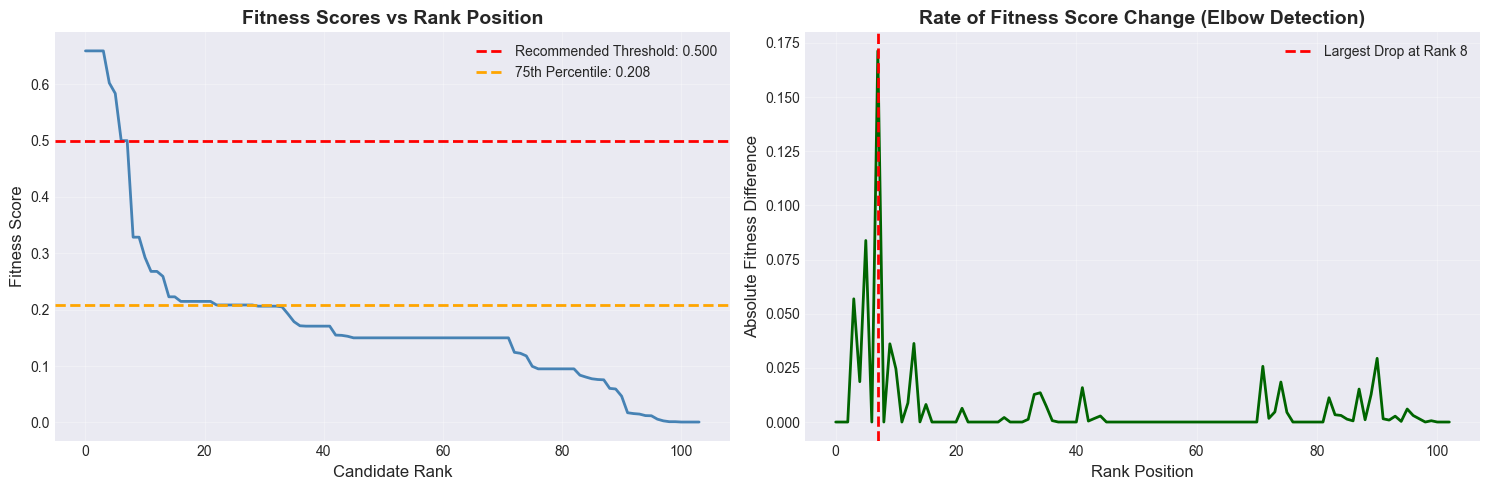

In [17]:
# Visualize cut-off analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sorted fitness scores with different thresholds
sorted_fit = ranked_df.sort_values('fit', ascending=False)['fit'].values
axes[0].plot(range(len(sorted_fit)), sorted_fit, linewidth=2, color='steelblue')
axes[0].axhline(recommended_threshold, color='red', linestyle='--', linewidth=2, 
                label=f'Recommended Threshold: {recommended_threshold:.3f}')
axes[0].axhline(np.percentile(sorted_fit, 75), color='orange', linestyle='--', linewidth=2,
                label=f'75th Percentile: {np.percentile(sorted_fit, 75):.3f}')
axes[0].set_xlabel('Candidate Rank', fontsize=12)
axes[0].set_ylabel('Fitness Score', fontsize=12)
axes[0].set_title('Fitness Scores vs Rank Position', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Fitness score differences (rate of change)
differences = np.abs(np.diff(sorted_fit))
axes[1].plot(range(len(differences)), differences, linewidth=2, color='darkgreen')
axes[1].axvline(np.argmax(differences), color='red', linestyle='--', linewidth=2,
                label=f'Largest Drop at Rank {np.argmax(differences) + 1}')
axes[1].set_xlabel('Rank Position', fontsize=12)
axes[1].set_ylabel('Absolute Fitness Difference', fontsize=12)
axes[1].set_title('Rate of Fitness Score Change (Elbow Detection)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Apply filtering and show filtered results
def filter_candidates(df, threshold):
    """
    Filter candidates below a fitness threshold.
    """
    filtered_df = df[df['fit'] >= threshold].copy()
    filtered_df = filtered_df.sort_values('fit', ascending=False).reset_index(drop=True)
    filtered_df['rank'] = range(1, len(filtered_df) + 1)
    return filtered_df

# Use 75th percentile as conservative threshold
conservative_threshold = np.percentile(ranked_df['fit'], 75)
filtered_candidates = filter_candidates(ranked_df, conservative_threshold)

print(f"Filtered Candidate Pool (threshold = {conservative_threshold:.4f}):")
print(f"Original candidates: {len(ranked_df)}")
print(f"Filtered candidates: {len(filtered_candidates)}")
print(f"Reduction: {len(ranked_df) - len(filtered_candidates)} candidates ({(len(ranked_df) - len(filtered_candidates))/len(ranked_df)*100:.1f}%)")
print(f"\nFiltered Top 20:")
filtered_candidates[['rank', 'job_title', 'location', 'connection', 'fit']].head(20)

Filtered Candidate Pool (threshold = 0.2083):
Original candidates: 104
Filtered candidates: 29
Reduction: 75 candidates (72.1%)

Filtered Top 20:


,rank,job_title,location,connection,fit
0,1,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.659281
1,2,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.659281
2,3,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.659281
3,4,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.659281
4,5,Seeking Human Resources Opportunities. Open to travel and relocation.,Amerika Birleşik Devletleri,415,0.602409
5,6,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,0.583787
6,7,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.499986
7,8,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.499986
8,9,Human Resources Generalist at Schwan's,Amerika Birleşik Devletleri,500+,0.328650
9,10,"Human Resources Generalist at ScottMadden, Inc.","Raleigh-Durham, North Carolina Area",500+,0.328650


## 7. Advanced Features & Automation Ideas

Ideas to reduce human bias and improve automation:

Diversity Analysis - Top 30 Candidates

Location Distribution:
location
Raleigh-Durham, North Carolina Area    8
Kanada                                 7
Greater Philadelphia Area              4
Amerika Birleşik Devletleri            2
Chicago, Illinois                      2
Houston, Texas Area                    2
Las Vegas, Nevada Area                 1
San Jose, California                   1
Greater New York City Area             1
Kokomo, Indiana Area                   1
Name: count, dtype: int64

Connection Distribution:
connection
500+     12
61        7
44        6
390       2
415       1
71        1
48        1
Name: count, dtype: int64


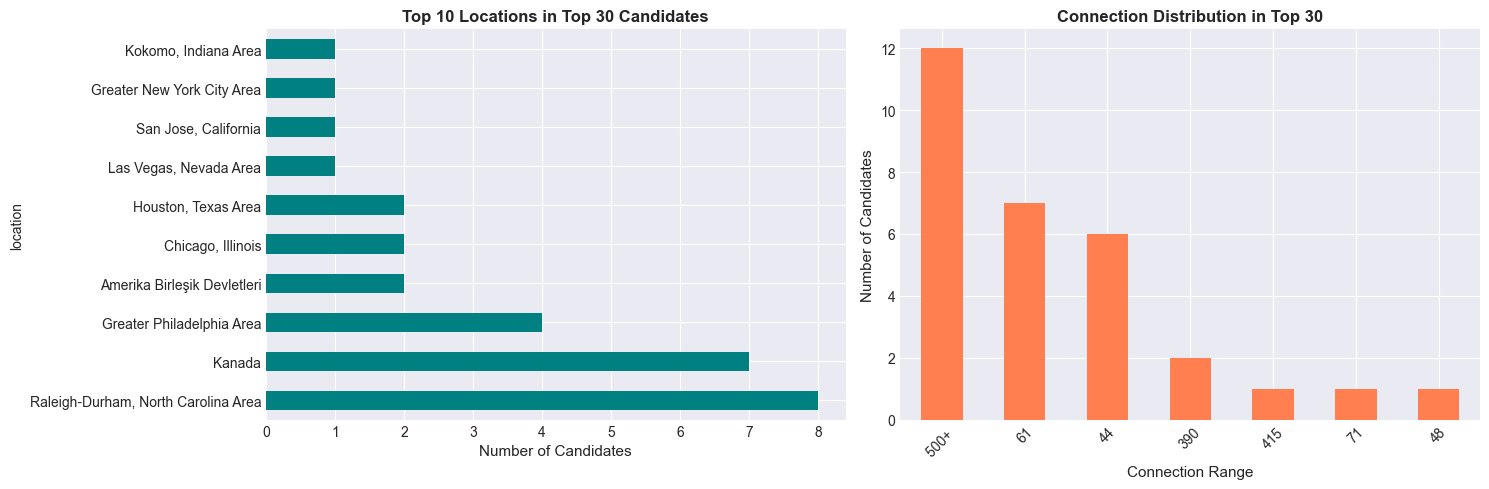

In [19]:
def diversity_analysis(df):
    """
    Analyze diversity in the candidate pool to reduce location bias.
    """
    print("Diversity Analysis - Top 30 Candidates")
    print("="*80)
    
    top_30 = df.head(30)
    
    # Location diversity
    location_dist = top_30['location'].value_counts()
    print(f"\nLocation Distribution:")
    print(location_dist.head(10))
    
    # Connection diversity
    connection_dist = top_30['connection'].value_counts()
    print(f"\nConnection Distribution:")
    print(connection_dist)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Top locations
    location_dist.head(10).plot(kind='barh', ax=axes[0], color='teal')
    axes[0].set_xlabel('Number of Candidates', fontsize=11)
    axes[0].set_title('Top 10 Locations in Top 30 Candidates', fontsize=12, fontweight='bold')
    
    # Connection distribution
    connection_dist.plot(kind='bar', ax=axes[1], color='coral')
    axes[1].set_xlabel('Connection Range', fontsize=11)
    axes[1].set_ylabel('Number of Candidates', fontsize=11)
    axes[1].set_title('Connection Distribution in Top 30', fontsize=12, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

diversity_analysis(ranked_df)

Keyword Analysis - Top 30 Candidates

Most Common Keywords in Top 30:
  human                :  30 occurrences (100.0%)
  resources            :  30 occurrences (100.0%)
  aspiring             :  16 occurrences (53.3%)
  generalist           :  14 occurrences (46.7%)
  professional         :   7 occurrences (23.3%)
  humber               :   7 occurrences (23.3%)
  college              :   7 occurrences (23.3%)
  hris                 :   4 occurrences (13.3%)
  positions            :   4 occurrences (13.3%)
  opportunities        :   3 occurrences (10.0%)
  management           :   2 occurrences (6.7%)
  internship           :   2 occurrences (6.7%)
  open                 :   1 occurrences (3.3%)
  travel               :   1 occurrences (3.3%)
  relocation           :   1 occurrences (3.3%)


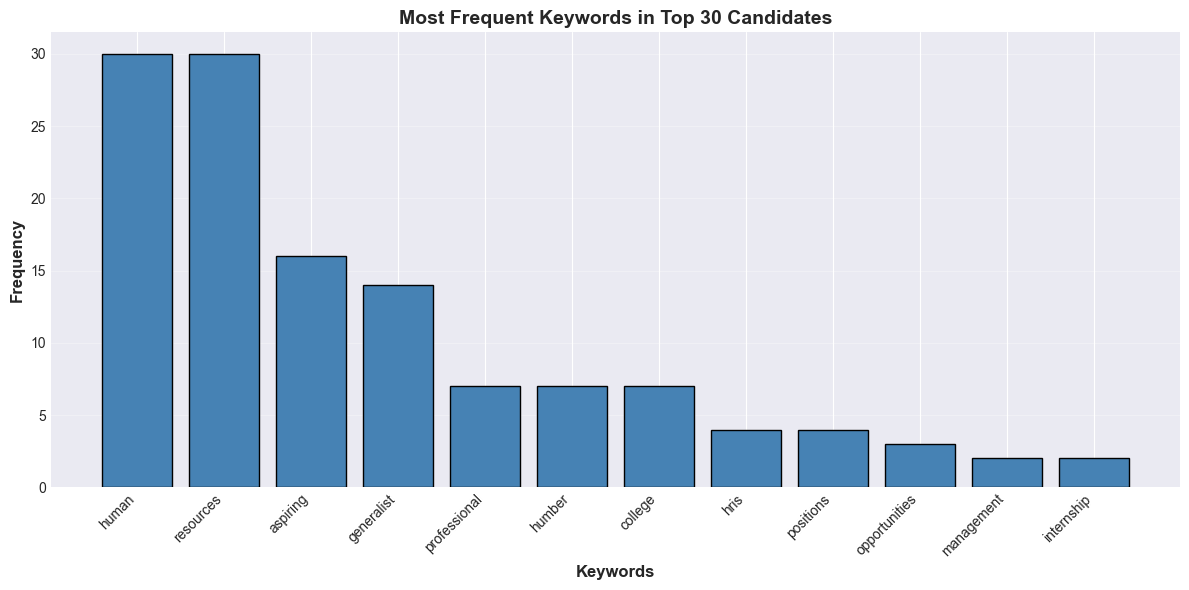

In [20]:
def keyword_analysis(df, top_n=30):
    """
    Extract and analyze common keywords/phrases in top candidates.
    This helps understand what makes a good candidate.
    """
    from collections import Counter
    import re
    
    print(f"Keyword Analysis - Top {top_n} Candidates")
    print("="*80)
    
    top_titles = df.head(top_n)['job_title'].tolist()
    
    # Extract words (exclude common stop words)
    all_words = []
    for title in top_titles:
        words = re.findall(r'\b[a-zA-Z]{3,}\b', title.lower())
        all_words.extend(words)
    
    # Count frequency
    word_freq = Counter(all_words)
    
    # Remove very common words
    stop_words = {'and', 'the', 'for', 'with', 'area', 'seeking', 'student'}
    word_freq = {k: v for k, v in word_freq.items() if k not in stop_words}
    
    print(f"\nMost Common Keywords in Top {top_n}:")
    for word, count in sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:15]:
        print(f"  {word:20s} : {count:3d} occurrences ({count/top_n*100:.1f}%)")
    
    # Visualize
    top_words = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:12])
    
    plt.figure(figsize=(12, 6))
    plt.bar(top_words.keys(), top_words.values(), color='steelblue', edgecolor='black')
    plt.xlabel('Keywords', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.title(f'Most Frequent Keywords in Top {top_n} Candidates', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

keyword_analysis(ranked_df, top_n=30)

## 8. Summary & Recommendations

In [21]:
print("="*100)
print("TALENT RANKING SYSTEM - SUMMARY REPORT")
print("="*100)

print(f"\n1. ALGORITHM PERFORMANCE:")
print(f"   • Total candidates evaluated: {len(df)}")
print(f"   • Ranking iterations performed: {len(ranking_system.ranking_history)}")
print(f"   • Candidates starred: {len(ranking_system.starred_candidates)}")
print(f"   • Current top candidate fit score: {ranked_df.iloc[0]['fit']:.4f}")

print(f"\n2. HOW THE SOLUTION WORKS:")
print(f"   • Uses TF-IDF vectorization with cosine similarity")
print(f"   • Matches job titles against role keywords (n-grams: 1-3)")
print(f"   • Incorporates connection count as secondary signal (20% weight)")
print(f"   • Learns from starred candidates via similarity propagation")
print(f"   • Adaptively increases weight on starred examples (up to 60%)")

print(f"\n3. RANKING IMPROVEMENT WITH STARRING:")
if len(ranking_system.ranking_history) > 1:
    initial_top = ranking_system.ranking_history[0]['fit'].head(10).mean()
    current_top = ranking_system.ranking_history[-1]['fit'].head(10).mean()
    improvement = ((current_top - initial_top) / initial_top) * 100
    print(f"   • Initial top-10 average fit: {initial_top:.4f}")
    print(f"   • Current top-10 average fit: {current_top:.4f}")
    print(f"   • Improvement: {improvement:+.2f}%")
else:
    print(f"   • Need more iterations to show improvement")

print(f"\n4. FILTERING RECOMMENDATIONS:")
print(f"   • Recommended threshold: {recommended_threshold:.4f}")
print(f"   • Conservative threshold (75th percentile): {conservative_threshold:.4f}")
print(f"   • Candidates retained at conservative level: {len(filtered_candidates)} ({len(filtered_candidates)/len(df)*100:.1f}%)")

print(f"\n5. AUTOMATION & BIAS REDUCTION IDEAS:")
print(f"   ✓ Use ensemble of multiple similarity metrics (Jaccard, Levenshtein, semantic)")
print(f"   ✓ Implement location-blind initial ranking to reduce geographic bias")
print(f"   ✓ Add temporal decay to older starred candidates (avoid stale preferences)")
print(f"   ✓ Use active learning to identify most informative candidates to review")
print(f"   ✓ Implement diversity constraints in top-k results")
print(f"   ✓ Add explanation features (why was this candidate ranked high?)")
print(f"   ✓ A/B test different ranking algorithms with recruiters")
print(f"   ✓ Consider using transformer-based embeddings (BERT, sentence-transformers)")

print(f"\n6. NEXT STEPS:")
print(f"   → Deploy system with real-time starring interface")
print(f"   → Collect more candidate features (skills, experience years, education)")
print(f"   → Build separate models for different role types")
print(f"   → Implement continuous model retraining pipeline")
print(f"   → Add confidence intervals for fit scores")

print("\n" + "="*100)

TALENT RANKING SYSTEM - SUMMARY REPORT

1. ALGORITHM PERFORMANCE:
   • Total candidates evaluated: 104
   • Ranking iterations performed: 4
   • Candidates starred: 3
   • Current top candidate fit score: 0.6593

2. HOW THE SOLUTION WORKS:
   • Uses TF-IDF vectorization with cosine similarity
   • Matches job titles against role keywords (n-grams: 1-3)
   • Incorporates connection count as secondary signal (20% weight)
   • Learns from starred candidates via similarity propagation
   • Adaptively increases weight on starred examples (up to 60%)

3. RANKING IMPROVEMENT WITH STARRING:
   • Initial top-10 average fit: 0.3940
   • Current top-10 average fit: 0.5481
   • Improvement: +39.10%

4. FILTERING RECOMMENDATIONS:
   • Recommended threshold: 0.5000
   • Conservative threshold (75th percentile): 0.2083
   • Candidates retained at conservative level: 29 (27.9%)

5. AUTOMATION & BIAS REDUCTION IDEAS:
   ✓ Use ensemble of multiple similarity metrics (Jaccard, Levenshtein, semantic)
   ✓

## 9. Export Results

In [22]:
# Save the final ranked list
output_df = ranked_df[['id', 'job_title', 'location', 'connection', 'fit', 'rank']].copy()
output_df.to_csv('ranked_candidates_with_fit.csv', index=False)

print("✓ Final ranked candidates saved to: ranked_candidates_with_fit.csv")

# Save filtered high-quality candidates
filtered_output = filtered_candidates[['id', 'job_title', 'location', 'connection', 'fit', 'rank']].copy()
filtered_output.to_csv('filtered_top_candidates.csv', index=False)

print("✓ Filtered candidates saved to: filtered_top_candidates.csv")
print(f"\nTotal candidates in filtered list: {len(filtered_output)}")

✓ Final ranked candidates saved to: ranked_candidates_with_fit.csv
✓ Filtered candidates saved to: filtered_top_candidates.csv

Total candidates in filtered list: 29


---
## Interactive Section: Try Your Own Starring

Use the cell below to interactively star candidates and see the ranking update!

In [23]:
# Interactive starring function
def interactive_star(current_df, rank_to_star):
    """
    Star a candidate at a specific rank and show updated rankings.
    
    Parameters:
    -----------
    current_df : DataFrame
        Current ranked dataframe
    rank_to_star : int
        The rank position of candidate to star
    """
    print(f"\n{'='*100}")
    print(f"STARRING CANDIDATE AT RANK {rank_to_star}")
    print(f"{'='*100}\n")
    
    updated_df = ranking_system.star_candidate(current_df, rank_to_star)
    
    print(f"\nUpdated Top 20 Rankings:")
    print(updated_df[['rank', 'job_title', 'location', 'fit']].head(20))
    
    print(f"\n✭ Total starred candidates: {len(ranking_system.starred_candidates)}")
    
    return updated_df

# Example: Star candidate at rank 7
ranked_df = interactive_star(ranked_df, rank_to_star=7)


STARRING CANDIDATE AT RANK 7


Updated Top 20 Rankings:
    rank  \
0      1   
1      2   
2      3   
3      4   
4      5   
5      6   
6      7   
7      8   
8      9   
9     10   
10    11   
11    12   
12    13   
13    14   
14    15   
15    16   
16    17   
17    18   
18    19   
19    20   

                                                                                              job_title  \
0                                                                 Seeking Human Resources Opportunities   
1                                                                 Seeking Human Resources Opportunities   
2                                                 Seeking Human Resources HRIS and Generalist Positions   
3                                                 Seeking Human Resources HRIS and Generalist Positions   
4                                                 Seeking Human Resources HRIS and Generalist Positions   
5                                               